# Imports and Global Variables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

testAll = []
trainAll = []

# Load and Prepare Data 

*Download the Raw text files for the main ‘BBC’ data set from http://mlg.ucd.ie/datasets/bbc.html. This will be a Zip file that contains text files with data.*

*You can read the files into a Pandas data frame with the following code:*

In [2]:
from pathlib import Path
articles = pd.DataFrame.from_records(
    ((f.parent.name, f.name, f.read_text(encoding='latin1'))
     for f in Path('bbc').glob('*/*.txt')),
    columns=['category', 'file', 'text']
)

*Set aside 20% of the data for testing your classifiers.*

In [3]:
rng = np.random.RandomState(20201031)
test = articles.sample(frac=0.25, random_state=rng)
train_mask = pd.Series(True, index=articles.index)
train_mask[test.index] = False
train = articles[train_mask].copy()
train.head()

,category,file,text
0,entertainment,289.txt,Musicians to tackle US red tape\n\nMusicians' ...
1,entertainment,262.txt,"U2's desire to be number one\n\nU2, who have w..."
4,entertainment,074.txt,Ocean's Twelve raids box office\n\nOcean's Twe...
6,entertainment,114.txt,Pete Doherty misses bail deadline\n\nSinger Pe...
7,entertainment,100.txt,Fockers retain film chart crown\n\nComedy Meet...


*Show the distribution of categories - how many articles are there in each category? Do this with a suitable plot.*

Text(0.5, 1.0, 'Distribution of Categories among Articles')

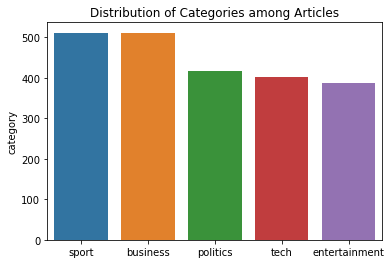

In [4]:
categories = pd.DataFrame(articles["category"].value_counts())
sns.barplot(x=categories.index, y='category', data= categories ).set_title("Distribution of Categories among Articles")

In [5]:
articles["category"].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

# Classification

*Train a naïve Bayes classifier (MultinomialNB) to predict an article's category using its term counts.*

In [6]:
bayes_pipe = Pipeline([
    ('word_count', CountVectorizer()),
    ('classify', MultinomialNB())
])
bayes_pipe.fit(train['text'], train['category'])

Pipeline(memory=None,
         steps=[('word_count',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classify',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

*Report its accuracy on both the training and the test data.*

In [7]:
print("Accuracy of NBC on training data: " + str(accuracy_score(train['category'], bayes_pipe.predict(train['text']))))
print("Accuracy of NBC on test data: " + str(accuracy_score(test['category'], bayes_pipe.predict(test['text']))))

trainAll.append(accuracy_score(train['category'], bayes_pipe.predict(train['text'])))
testAll.append(accuracy_score(test['category'], bayes_pipe.predict(test['text'])))

Accuracy of NBC on training data: 0.9928100659077291
Accuracy of NBC on test data: 0.9820143884892086


*Train a k-NN classifier (KNeighborsClassifier) with 5 neighbors on TF-IDF term vectors.*

In [8]:
knn = Pipeline([
    ('word_count', TfidfVectorizer()),
    ('classify', KNeighborsClassifier(n_neighbors=5))
])
knn.fit(train['text'], train['category'])

Pipeline(memory=None,
         steps=[('word_count',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classify',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_pa

Report its accuracy on both the training and the test data. You can do this with a pipeline.

In [9]:
print("Accuracy of k-NN classifier with 5 neighbors on training data: " + str(accuracy_score(train['category'], knn.predict(train['text']))))
print("Accuracy of k-NN classifier with 5 neighbors on test data: " + str(accuracy_score(test['category'], knn.predict(test['text']))))

trainAll.append(accuracy_score(train['category'], knn.predict(train['text'])))
testAll.append(accuracy_score(test['category'], knn.predict(test['text'])))

Accuracy of k-NN classifier with 5 neighbors on training data: 0.9484721390053924
Accuracy of k-NN classifier with 5 neighbors on test data: 0.9370503597122302


*Train a k-NN classifier with GridSearchCV to pick the neighborhood size.*

In [10]:
knn = Pipeline([
    ('word_count', TfidfVectorizer()),
    ('classify', KNeighborsClassifier())
])
param_grid = {
     'classify__n_neighbors': [1, 2, 3, 5, 7, 10]
   }

grid = GridSearchCV(knn, param_grid)

In [11]:
grid.fit(train['text'], train['category'])

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('word_count',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                 

In [12]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.462141,0.013972,0.189804,0.009084,1,{'classify__n_neighbors': 1},0.910180,0.913174,0.877246,0.907186,0.903904,0.902338,0.012919,4
1,0.479944,0.018297,0.190885,0.004636,2,{'classify__n_neighbors': 2},0.916168,0.889222,0.883234,0.886228,0.912913,0.897553,0.014037,6
2,0.482072,0.011950,0.213520,0.033791,3,{'classify__n_neighbors': 3},0.901198,0.910180,0.886228,0.901198,0.894895,0.898739,0.007928,5
3,0.505301,0.022788,0.202328,0.013813,5,{'classify__n_neighbors': 5},0.901198,0.931138,0.898204,0.901198,0.927928,0.911933,0.014448,2
4,0.482453,0.029457,0.201113,0.007244,7,{'classify__n_neighbors': 7},0.901198,0.928144,0.892216,0.907186,0.915916,0.908932,0.012330,3
5,0.460776,0.016262,0.188193,0.004323,10,{'classify__n_neighbors': 10},0.916168,0.928144,0.874251,0.925150,0.918919,0.912526,0.019608,1


In [13]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('word_count',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classify',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_pa

In [14]:
grid.best_score_

0.9125262987538436

*Report its accuracy on both the training and test data.*

In [15]:
knn = Pipeline([
    ('word_count', TfidfVectorizer()),
    ('classify', KNeighborsClassifier(n_neighbors=10))
])
knn.fit(train['text'], train['category'])

print("Accuracy of k-NN classifier passed through a GridSearch on training data: " + str(accuracy_score(train['category'], knn.predict(train['text']))))
print("Accuracy of k-NN classifier passed through a GridSearch on test data: " + str(accuracy_score(test['category'], knn.predict(test['text']))))

testAll.append(accuracy_score(test['category'], knn.predict(test['text'])))
trainAll.append(accuracy_score(train['category'], knn.predict(train['text'])))

Accuracy of k-NN classifier passed through a GridSearch on training data: 0.9340922708208508
Accuracy of k-NN classifier passed through a GridSearch on test data: 0.9370503597122302


*Does tuning the neighborhood size result in better test accuracy?*

It does seem that tuning the neighborhood size using GridSearchCV actually decreases the test accuracy, but about the same results for test data. One would suspect that using more neighborhoods has decreased the overfitting, especially because GridSearch is using cross validation. 

*Train a k-NN classifier with 5 neighbors on the SVD-transformed article texts. You can do this with a 3-stage pipeline. Report its accuracy on both the training and the test data.*

In [16]:
svd_pipe = Pipeline([
    ('word_vec', TfidfVectorizer()),
    ('svd', TruncatedSVD(8)),
    ('classify', KNeighborsClassifier(n_neighbors=5))
])

svd_pipe.fit(train['text'], train['category'])

Pipeline(memory=None,
         steps=[('word_vec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svd',
                 TruncatedSVD(algorithm='randomized', n_components=8, n_iter=5,
                              random_state=None, tol=0.0)),
    

In [17]:
print("Accuracy of SVD classifier on training data: " + str(accuracy_score(train['category'], svd_pipe.predict(train['text']))))
print("Accuracy of SVD classifier on test data: " + str(accuracy_score(test['category'], svd_pipe.predict(test['text']))))

testAll.append(accuracy_score(test['category'], svd_pipe.predict(test['text'])))
trainAll.append(accuracy_score(train['category'], svd_pipe.predict(train['text'])))

Accuracy of SVD classifier on training data: 0.9550629119233074
Accuracy of SVD classifier on test data: 0.9550359712230215


# Summarizing Classifier Accuracy 

*At this point, you should have 4 different classifiers.*

*Show the accuracy of your 4 different classifiers on both the training and test data with an appropriate table and plot.* 

In [18]:
accuracyComp = pd.DataFrame(columns = ['test','train'], index = ['bayes', 'knn', 'grid', 'svd'])
accuracyComp['test'] = testAll[:4]
accuracyComp['train'] = trainAll[:4]
accuracyComp['difference'] = accuracyComp['train'] - accuracyComp['test']

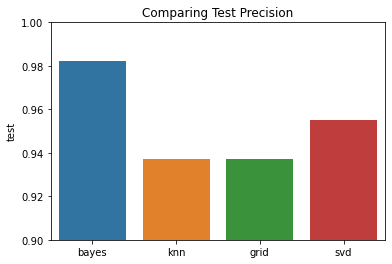

In [19]:
a_plot = sns.barplot(x = accuracyComp.index, y = 'test', data = accuracyComp)
a_plot.set(ylim=(.9, 1))
a_plot.set_title("Comparing Test Precision")
plt.show()

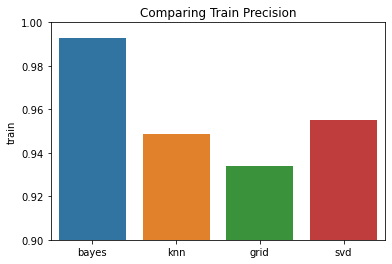

In [20]:
a_plot = sns.barplot(x = accuracyComp.index, y = 'train', data = accuracyComp)
a_plot.set(ylim=(.9, 1))
a_plot.set_title("Comparing Train Precision")
plt.show()

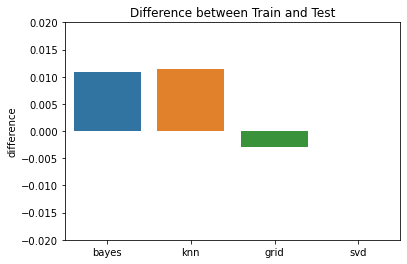

In [21]:
a_plot = sns.barplot(x = accuracyComp.index, y = 'difference', data = accuracyComp)
a_plot.set(ylim=(-.02, .02))
a_plot.set_title("Difference between Train and Test")
plt.show()

*Which classifier design performs the best? Which classifier seems to overfit the most in the training process?*

The classifier that performs the best is the naive Bayes classifier. However, it seems that both that classifier, as well as the KNN classifier seem to overfit on the training process. Though I hesitate to say there is too much overfitting, considering the maximum 1 point difference between accuracy of training and testing. It really depends on what the threshold for overfitting would be. However, if forced to answer the question, I would say both the bayes and knn classifier run the risk of overfitting, while the gridcv and svd seem to deal with overfitting.

# Clustering

*Fit a k-means model with 5 clusters, using TF-IDF vectors, and plot the cluster/category alignment as described above.*

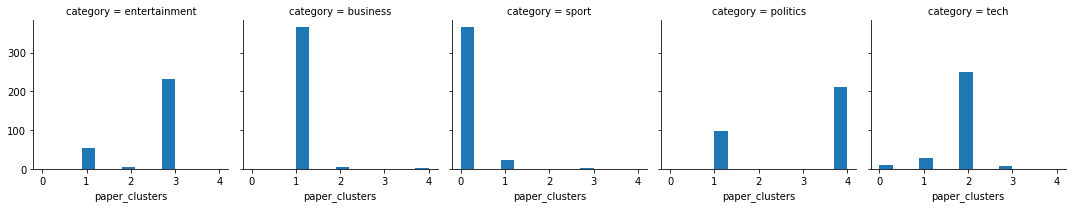

In [22]:
cluster_pipe5 = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('cluster', KMeans(5, random_state=rng))
])

cluster_pipe5.fit(train['text'])

paper_clusters = cluster_pipe5.predict(train['text'])

train['paper_clusters'] = paper_clusters

g = sns.FacetGrid(train, col='category')
g.map(plt.hist, 'paper_clusters')

*Do you think the clustering did a good job of finding the categories?*

The clustering technique seems to work rather well, if we are taking majority values for clustering. Like, for politics if we count politics as 4 instead of 1, as more of these are in cluster 4, then clustering appears to work really well. Especially when the majority class is overwhelming (like sport or business).

*Repeat with 6 clusters.*

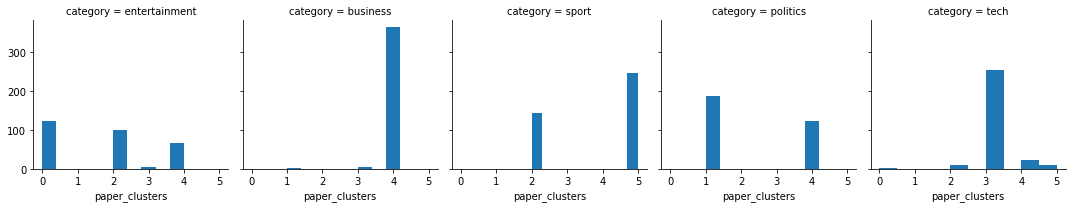

In [28]:
cluster_pipe6 = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('cluster', KMeans(6, random_state=rng))
])

cluster_pipe6.fit(train['text'])

paper_clusters = cluster_pipe6.predict(train['text'])

train['paper_clusters'] = paper_clusters

g = sns.FacetGrid(train, col='category')
g.map(plt.hist, 'paper_clusters')

*Do you think this clustering does a better or worse job? Explain why, using evidence from the plots (and if you think additional analyses would be useful, include them to support your argument).*

As I was expecting, using 6 clusters works less well than 5 clusters. Considering that there are 5 categories we are attempting to cluster, it makes logical sense that the more clusters we employ, the less clearly defined groups we will find in each cluster. For example; I have seen a number of runs where there were even splits between categories; which could make performing classification a bit confusing. To be noted, since we are using k-means, it returns results different times, so the clusters used in the code below may not be valid if this code is run again.

*For each cluster in the clustering you think did a better job, find the words that are most important for that cluster. The KMeans object, after it has been fit, has a cluster_centers_ field containing a matrix. There is a row for each cluster, and the columns are features (in our case, words); it says where in word-space the middle of that cluster is. What words have the largest values for each cluster? You can get the words with the vectorizer’s get_feature_names() method. You can get a row of the matrix with matrix[row, :], and use that with the feature names to make a series.*

In [29]:
keywords = cluster_pipe5['vectorize'].get_feature_names()

politics = np.array(cluster_pipe5['cluster'].cluster_centers_[4])
tech = np.array(cluster_pipe5['cluster'].cluster_centers_[2])
entertainment = np.array(cluster_pipe5['cluster'].cluster_centers_[3])
sport = np.array(cluster_pipe5['cluster'].cluster_centers_[0])
business = np.array(cluster_pipe5['cluster'].cluster_centers_[1])

techMax = np.argmax(tech)
sportMax = np.argmax(sport)
businessMax = np.argmax(business)
politicsMax = np.argmax(politics)
entertainmentMax = np.argmax(entertainment)

keywords[techMax]
keywords[sportMax]
keywords[businessMax]
keywords[politicsMax]
keywords[entertainmentMax]

print("The top word for tech in the 5 cluster is: " + keywords[techMax] )
print("The top word for sports in the 5 cluster is: " + keywords[sportMax] )
print("The top word for business in the 5 cluster is: " + keywords[businessMax] )
print("The top word for politics in the 5 cluster is: " + keywords[politicsMax] )
print("The top word for entertainment in the 5 cluster is: " + keywords[entertainmentMax] )

The top word for tech in the 5 cluster is: mobile
The top word for sports in the 5 cluster is: game
The top word for business in the 5 cluster is: said
The top word for politics in the 5 cluster is: mr
The top word for entertainment in the 5 cluster is: film


In [31]:
keywords = cluster_pipe6['vectorize'].get_feature_names()

tech = np.array(cluster_pipe6['cluster'].cluster_centers_[3])
politics = np.array(cluster_pipe6['cluster'].cluster_centers_[1])
sport = np.array(cluster_pipe6['cluster'].cluster_centers_[4])
business = np.array(cluster_pipe6['cluster'].cluster_centers_[4])
entertainment = np.array(cluster_pipe6['cluster'].cluster_centers_[0])

techMax = np.argmax(tech)
sportMax = np.argmax(sport)
businessMax = np.argmax(business)
politicsMax = np.argmax(politics)
entertainmentMax = np.argmax(entertainment)

keywords[techMax]
keywords[sportMax]
keywords[businessMax]
keywords[politicsMax]
keywords[entertainmentMax]

print("The top word for tech in the 6 cluster is: " + keywords[techMax] )
print("The top word for sports in the 6 cluster is: " + keywords[sportMax] )
print("The top word for business in the 6 cluster is: " + keywords[businessMax] )
print("The top word for politics in the 6 cluster is: " + keywords[politicsMax] )
print("The top word for entertainment in the 6 cluster is: " + keywords[entertainmentMax] )

The top word for tech in the 6 cluster is: mobile
The top word for sports in the 6 cluster is: said
The top word for business in the 6 cluster is: said
The top word for politics in the 6 cluster is: mr
The top word for entertainment in the 6 cluster is: film


 *Do these words make sense in light of the documents in that cluster?*
 
 I think that the 5 cluster words make a fair amount of sense, and the 6 cluster words mostly echo that. I also think that these top words are interesting, and reflect the nature of these articles. Mobile makes a lot of sense for tech, as that is a burgeoning field of technology. Game seems intuitive for sports, because sports games. I can see how said is an important word in the field of business, as business seems to be based a lot on what people have said! Mr also makes sense for politics, if only for the fact that a lot of politicians are Mr. so and so. What is interesting is the said in both business and sports, which makes me think there are probably a lot of interviews.

# Reflection

*Write 2–3 paragraphs about what you learned from this assignment. Please be specific — I would like you to reflect on particular things you learned about text classification or clustering, or about this data, and not just say general things about learning about text. What surprised you in this project?*

One of the primary take aways from this assignment is the power of a naive Bayes classifier performing classification on text. I have noticed very similar results in some of my own research, which makes me question how effective this kind of classifier can be. I also wonder how this effectiveness changes when we increase the size of the data set, or change the features to not be unigram, but bigram or trigram as well. I think that increasing the size of the data set would require a different n-gram other than uni, because it would increase the occurence of certain words? But, I could also seeing it having the reverse effect. I think that there could definitely be an issue with overfitting using NBC. Maybe using cross validation would help with this.

Another take-away is the impact that cross validation can have. When looking at the grid search, we see that the results on the training data is a bit lower, but I suspect this is due to the training data being split into a further subset of test and train in the process of cross validation. However, I think that cross validation can help with preventing over fitting, which is an important trait. I suppose that I am aware of that, in theory, but had not seen it executed in practice. Also, we see the SVD doing an impressive job of preventing overfitting, compared to the bayes and non-grid kNN. But who knows what the magical math of the svd has determined as features.

However, I think the strongest takeaway from this homework assignment is the comfort, ease, and what I've learned in terms of using Seaborn. For a long time I've almost been scared of the library, not quite sure how to use it; to get it to visualize what I want it to represent. This assignment has helped to cement my skill with using this library, and also has revealed to me how powerful this library can be. I was so relieved that sns.pairplot didn't require a declaration of X value if there are numerically labeled columns. What a relief! By this assignment, I have finally learned how to use sns comfortably.